In [17]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy

# Part.1 Chooser Option Pricing

In [18]:
ticker_list = ["^GSPC", 'AAPL']
start_date = '2021-11-01'
end_date = '2022-11-03'

In [10]:
#sp500 = pdr.DataReader("^GSPC", start = start_date, end = end_date, data_source = 'yahoo')
#sp500.head()
#plt.figure(figsize = (16,9))
#sp500['Adj Close'].plot(title = 'S&P500 - Adj Close Price')

In [26]:
#aapl = pdr.DataReader("AAPL", start = start_date, end = end_date, data_source = 'yahoo')
aapl = yf.download('AAPL', start = start_date, end = end_date, auto_adjust = True)
aapl_w = yf.download('AAPL', start = '2020-04-20', end ='2022-10-02', interval = '1wk', auto_adjust = True)
aapl_w = aapl_w.dropna()
aapl.head(20)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2021-11-01,147.914426,148.619292,146.733014,147.884644,74588300
2021-11-02,147.586799,150.475794,147.576861,148.936981,69122000
2021-11-03,149.304297,150.872893,148.738420,150.396362,54511500
2021-11-04,150.485697,151.329552,149.552481,149.870178,60394600
2021-11-05,151.013555,151.321764,149.194112,150.407074,65463900
2021-11-08,150.536319,150.695399,149.293532,149.571915,55020900
2021-11-09,149.333308,150.556206,149.194116,149.939789,56787900
2021-11-10,149.154340,149.263706,146.996864,147.066452,65187100
2021-11-11,148.100476,148.567750,146.827848,147.016754,41000000


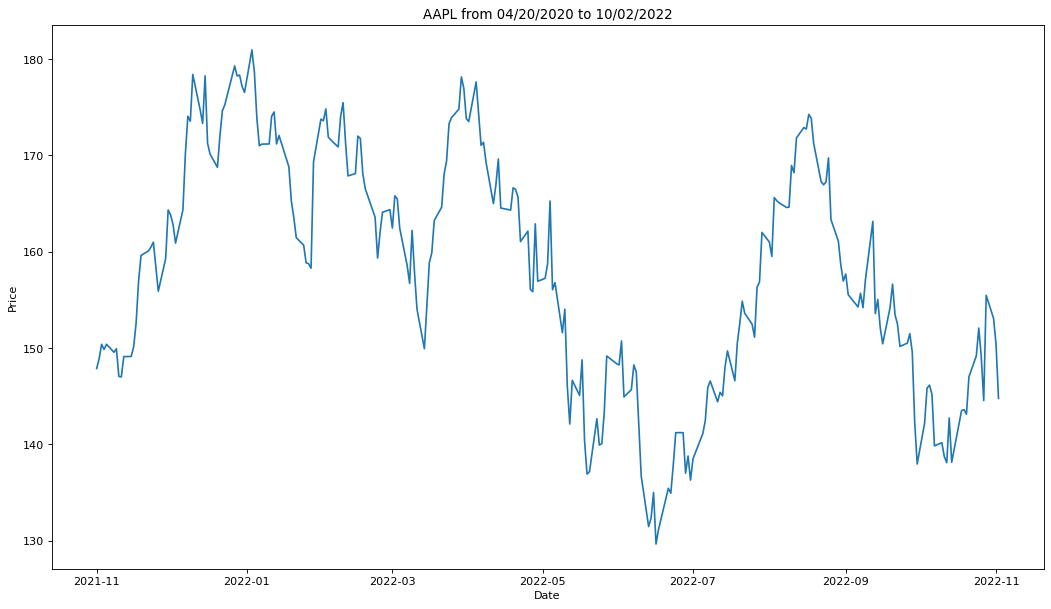

In [28]:
fig = plt.figure(figsize = (16,9), dpi = 80)
plt.plot(aapl['Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL from 04/20/2020 to 10/02/2022')
plt.show()

In [29]:
aapl_daily_return = aapl['Close'].pct_change()
aapl_daily_return = aapl_daily_return.dropna()
sigma_daily = aapl_daily_return.std()
sigma_annually = sigma_daily * np.sqrt(252)
print(sigma_annually)

0.33921676397427736


In [31]:
one_year_Tbill = 0.045   # Risk free rate
aapl['Close'][0]    # Stock price on 10-02-2022

147.8846435546875

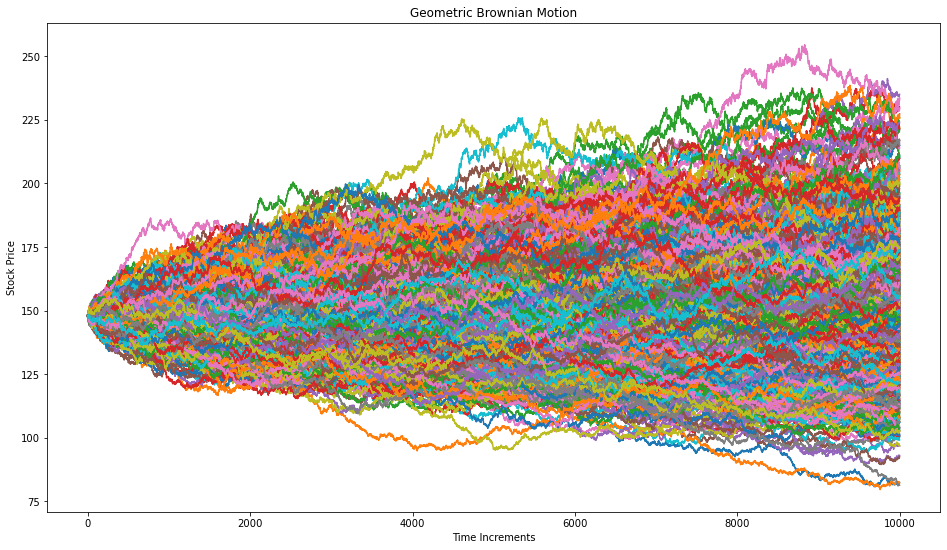

In [32]:
def geo_paths(S, T, r, q, sigma, steps, N):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # [steps,N] Matrix of asset paths 
    """
    dt = T/steps
    #S_{T} = ln(S_{0})+\int_{0}^T(\mu-\frac{\sigma^2}{2})dt+\int_{0}^T \sigma dW(t)
    ST = np.log(S) +  np.cumsum(((r - q - sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=(steps,N))),axis=0)
    return np.exp(ST)

S = aapl['Close'][0] #stock price S_{0}
#K = 68 # strike
T = 90/360 # time to maturity
r = 0.045 # risk free risk in annual %
q = 0.0065 # annual dividend rate
sigma = sigma_annually # annual volatility in %
steps = 10000 # time steps
N = 1000 # number of trials

paths= geo_paths(S,T,r, q,sigma,steps,N)

plt.figure(figsize = (16,9))
plt.plot(paths);
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")
plt.show()

In [34]:
def black_scholes_call(S,K,T,r,q,sigma):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # call_price = value of the option 
    """
    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / sigma*np.sqrt(T)
    d2 = d1 - sigma* np.sqrt(T)
    
    call = S * np.exp(-q*T)* norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)
    return call

S = aapl['Close'][0] #stock price S_{0}
K = 148 # strike
T = 90/360 # time to maturity
r = 0.045 # risk free risk in annual %
q = 0.0065 # annual dividend rate
t = 60/360 # Choice date
sigma = sigma_annually # annual volatility in %
steps = 10000 # time steps
N = 1000 # number of trials


payoffs = np.maximum(paths[-1]-K, 0)
option_price = np.mean(payoffs)*np.exp(-r*T) #discounting back to present value

bs_price = black_scholes_call(S,K,T,r,q,sigma)

print(f"Black Scholes Price is {bs_price}")
print(f"Simulated price is {option_price}")

Black Scholes Price is 10.545628142370347
Simulated price is 11.056798912879563


In [35]:
N=10000
paths= geo_paths(S, T, r, q,sigma, steps, N)
payoffs = np.maximum(paths[-1]-K, 0)
option_price = np.exp(-r*T)*np.mean(payoffs)

bs_price = black_scholes_call(S,K,T,r,q,sigma)

print(f"Black Scholes Price is {bs_price}")
print(f"Simulated price is {option_price}")

Black Scholes Price is 10.545628142370347
Simulated price is 10.636274152076572


In [36]:
# Closed form solution of Chooser options
def chooser_option_Cl(S,K,T,r,q,sigma,t):
    chooser = black_scholes_call(S,K,T,r,q,sigma) + np.maximum(0, K*np.exp(-r*(T-t))-S*np.exp(r*t)*np.exp(-q*(T-t)))
    chooser_0 = chooser*np.exp(-r*t)
    return chooser_0

chooser_apple = chooser_option_Cl(S,K,T,r,q,sigma,t)
print(f"Closed form solution of chooser option on AAPL is {chooser_apple}")

Closed form solution of chooser option on AAPL is 10.466831786992804


In [37]:
S = aapl["Close"][187]
S

161.0188446044922

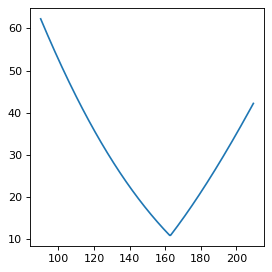

10.794983193999675


In [42]:
# plot chooser option price with different K while everything else unchanged.
S = aapl["Close"][187]                              # Asset price
K = np.arange(90, 210, 0.5)         # Strike price
T = 90/360                           # Time to maturity
t = 60/360                           # Choie time 

Price = []
for i in range(len(K)):
    p = chooser_option_Cl(S, K[i], T, r, q, sigma, t)
    Price.append(p)
    

fig = plt.figure(figsize = (3.5,3.5), dpi = 80)
plt.plot(K, Price)
#plt.title("3 Month - Chooser Option Prices with t = 2 months, S = 161, Different K")
plt.savefig('chooser option price vs k.jpg', dpi = 550)
plt.tight_layout()
plt.show()
print(min(Price))

In [37]:
Price[160]

22.411485189799503

In [18]:
S = aapl['Adj Close'][-1] #stock price S_{0}
K = 150 # strike
T = 1 # time to maturity
r = 0.045 # risk free risk in annual %
q = 0.0065 # annual dividend rate
t = 0.5 # Choice date
sigma = sigma_annually # annual volatility in %
steps = 10000 # time steps
N = 1000 # number of trials

In [19]:

# Monte Carlo Simulation 
def chooser_option_pricing(S,K,T,r,q,sigma,t):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    #t = choice time
    
    Output
    # chooser_option_price = value of the option 
    """
    payoffs = np.maximum(paths[-1]-K, 0)
    call_option_price = np.mean(payoffs)*np.exp(-r*(T-t)) #discounting back to time t
    
    chooser_t = call_option_price + np.maximum(0, K*np.exp(-r*(T-t))-np.mean(paths[int(steps*t)])*np.exp(-q*(T-t)))
    chooser_0 = chooser_t * np.exp(-r*t)
    
    
    return chooser_0

example = chooser_option_pricing(S,K,T,r,q,sigma,t)


print(f"Chooser Option Price on AAPL is {example}")

Chooser Option Price on AAPL is 21.852185294430306


In [20]:
def straddle(S,K,T,r,q,sigma):
    payoff = np.mean(np.maximum(paths[-1]-K, 0) + np.maximum(K - paths[-1],0))
    current = payoff * np.exp(-r*(T))
    return current

stra = straddle(S,K,T,r,q,sigma)
stra

38.512402776490134

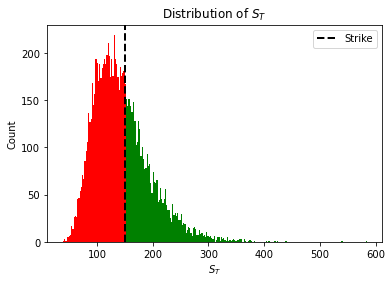

In [21]:
n, bins, patches = plt.hist(paths[-1],bins=250);
for c, p in zip(bins, patches):
    if c > K:
        plt.setp(p, 'facecolor', 'green')
    else:
        plt.setp(p, 'facecolor', 'red')
        
plt.axvline(K, color='black', linestyle='dashed', linewidth=2,label="Strike")
plt.title("Distribution of $S_{T}$")
plt.xlabel("$S_{T}$")
plt.ylabel('Count')
plt.legend()

# Part.2 Chooser Option Hedging

In [61]:
## Write a function to calculate delta. 
def CHOOSER_DELTA(S, K, T, t, r, q, sig):
    
    d1 = (np.log(S/K) + (r - q + sig**2/2)*T) / sig*np.sqrt(T)
    d2 = d1 - sig * np.sqrt(T)
    
    D1 = (np.log(S/K) + (r - q) * T + (t * sig**2/2)) / sig*np.sqrt(T)
    D2 = D1 - sig * np.sqrt(t)
    
    delta = np.exp(-q * T) * norm.cdf(d1) + np.exp(-q * t) * (norm.cdf(D1) - 1)
        
    return(delta)

In [15]:
## plot strike prices, K, on x-axis and Delta on y-axis
S = np.arange(50, 250)              # Asset price
K = np.arange(110, 190, 0.5)         # Strike price
T = 1                                # Time to maturity
t = [7/360, 30/360, 90/360, 180/360] # Time to choose

In [16]:
r = 0.045 # risk free risk in annual %
q = 0.0065 # annual dividend rate
sigma = sigma_annually # annual volatility in %
sigma

0.3411881156686974

In [25]:
k120_delta = []
for i in range(0, 200):
    d = CHOOSER_DELTA(S[i], K = 120, T = 360/360, r = 0.045, sig = sigma, t = 90/360, q = 0.0065)
    k120_delta.append(d)

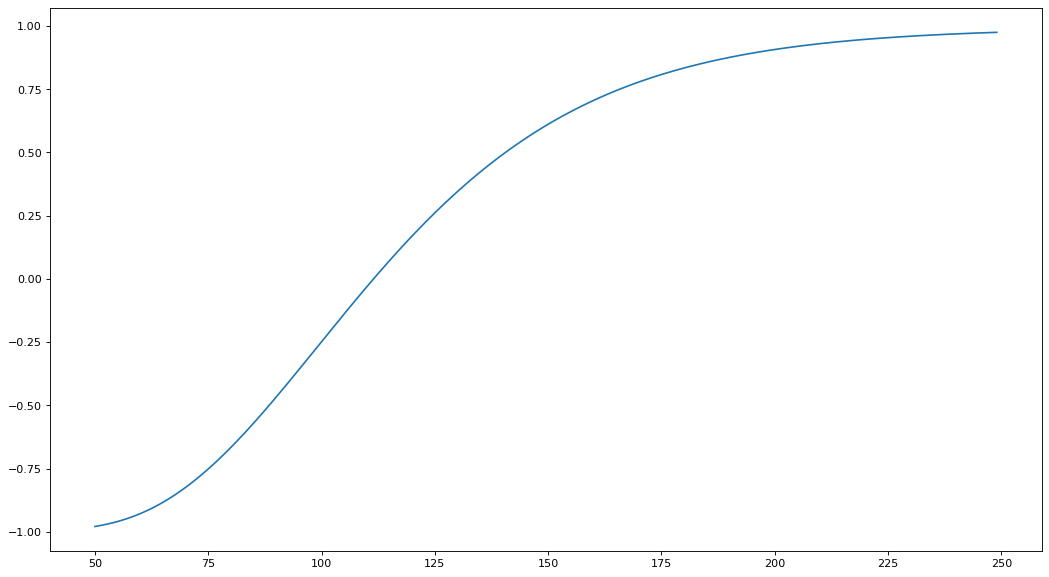

In [26]:
fig = plt.figure(figsize = (16,9), dpi = 80)
plt.plot(S, k120_delta)

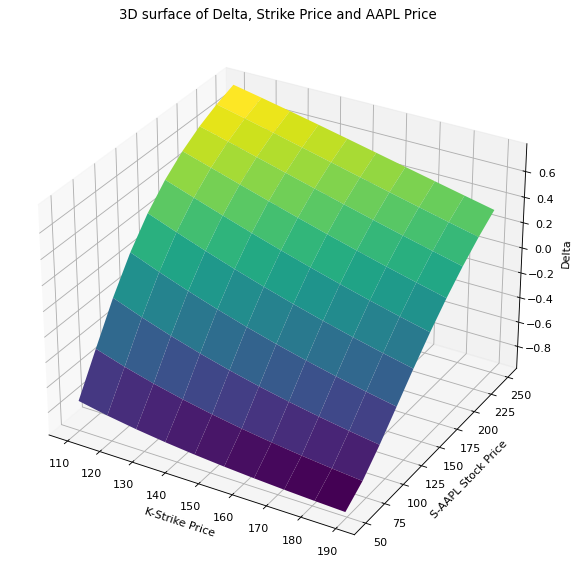

In [27]:
# t = 30/360 , T = 90/360.........
x_strike = []
y_price = []
z_delta = []
for i in range(0, 160):
    for j in range(0, 200):
        Delta = CHOOSER_DELTA(S[j], K[i], T = 90/360, r = 0.045, sig = sigma, t = 30/360, q = 0.0065)
        x_strike.append(K[i])
        y_price.append(S[j])
        z_delta.append(Delta)   

plotx,ploty, = np.meshgrid(np.linspace(np.min(x_strike), np.max(x_strike), 10),\
                           np.linspace(np.min(y_price), np.max(y_price), 10))
plotz = interp.griddata((x_strike, y_price), z_delta, (plotx,ploty), method='linear')

fig = plt.figure(figsize = (16,9), dpi = 80)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('K-Strike Price')
ax.set_ylabel('S-AAPL Stock Price')
ax.set_zlabel('Delta')
ax.set_title('3D surface of Delta, Strike Price and AAPL Price ')
ax.plot_surface(plotx, ploty, plotz, cstride=1, rstride=1, cmap='viridis') 

In [140]:
## Run 100 delta hedge scenarios.

## plot the histogram of PnL. 

# Conclusion. How much does it cost to run a delta hedge on average?

In [ ]:
# Assume we long a 3-month chooser option at 08/01/2022, 2-month later at 10/01/2022 we make a put or call choice,
# then the option expires at 11/01/2022, we run differents delta hedge scenarios and plot the historgam of PnL.
# Assume we have 10000 shares of AAPL stock.  

In [ ]:
delta hedging:  delta * contracts*100 + shares = 0 # at time 08/01/2022, contracts number calculated
#at time t: 10/01/2022, calculate expected value of call or put , compare , choose the greater value
#at tmme T: 11/01/2022, profit = (ST - S) + (ST - K) or (K - ST) - premium , calculate PnL
#try different K and 


# Chooser Option Buyer

In [43]:
Adj_Close_20220801 = aapl.loc['2022-08-01']['Close']
Adj_Close_20220930 = aapl.loc['2022-09-30']['Close']
Adj_Close_20221101 = aapl.loc['2022-11-01']['Close']
#shares = 10000
contracts = 1

def option_buyer_pnl(S, K, T, r, q, sigma, t, S1, S2):
    
    # option premium
    o_price = chooser_option_Cl(S, K, T, r, q, sigma, t)
    
    # at time 0, build up portfolio
    #contracts = (- shares * Adj_Close_20220801) / delta
    premium = contracts * o_price
    
    #pnl_on_stock = (Adj_Close_20221101 - Adj_Close_20220801) * shares
    
    # at time t, decide to choose either call or put
    c = black_scholes_call(S1, K, T = 30/360, r = 0.045, q = 0.0065, sigma = sigma_annually)
    p = c + K * np.exp(-r * T) - S1
    
    if c >= p:
        # we choose call, pnl calculated as follow
        pnl_option = max((S2 - K),0) * contracts - premium
    else:
        # we choose put , pnl calculated as follow
        pnl_option = max((K - S2),0) * contracts - premium 
    return(pnl_option)

In [44]:
Adj_Close_20220930 # Choice time

137.9711151123047

In [45]:
Adj_Close_20221101 # End 

150.40049743652344

In [46]:
S = Adj_Close_20220801 
K = np.arange(60,210)
T = 90/360
t = 60/360
r = 0.045 
q = 0.0065 
sigma = sigma_annually
S1 = Adj_Close_20220930 
S2 = Adj_Close_20221101

In [47]:
Adj_Close_20220801 # T0

161.0188446044922

In [48]:
pnl_option = []
for i in range(len(K)):
    a = option_buyer_pnl(S, K[i], T, r, q, sigma, t, S1, S2)
    pnl_option.append(a)

pnl_option

[-4.904873550979374,
 -4.742088795009394,
 -4.5811935985698256,
 -4.422496983034492,
 -4.266301264789021,
 -4.112901753885623,
 -3.962586494714216,
 -3.8156360458281995,
 -3.6723232961792007,
 -3.532913315134792,
 -3.397663233773571,
 -3.2668221550756726,
 -3.1406310907466377,
 -3.0193229225338314,
 -2.9031223860111623,
 -2.7922460749240656,
 -2.6869024642970913,
 -2.5872919506153096,
 -2.4936069074946943,
 -2.406031755356125,
 -2.3247430437140792,
 -2.2499095447823123,
 -2.1816923571857814,
 -2.1202450186517012,
 -2.0657136266307674,
 -2.018236965874223,
 -1.9779466420634577,
 -1.944967220655485,
 -1.9194163701694293,
 -1.901405009200154,
 -1.8910374564992125,
 -1.8884115835167137,
 -1.8936189688464609,
 -1.9067450540619646,
 -1.9278693004759972,
 -1.957065346393975,
 -1.9944011644717818,
 -2.039939218821665,
 -2.093736621543897,
 -2.1558452883923565,
 -2.2263120933093177,
 -2.3051790215934176,
 -2.3924833214869636,
 -2.488257653993365,
 -2.5925302407554227,
 -2.705325009845616,
 -2.8

In [49]:
pnl_option[102]

0.5840047147811251

In [50]:
K[102]

162

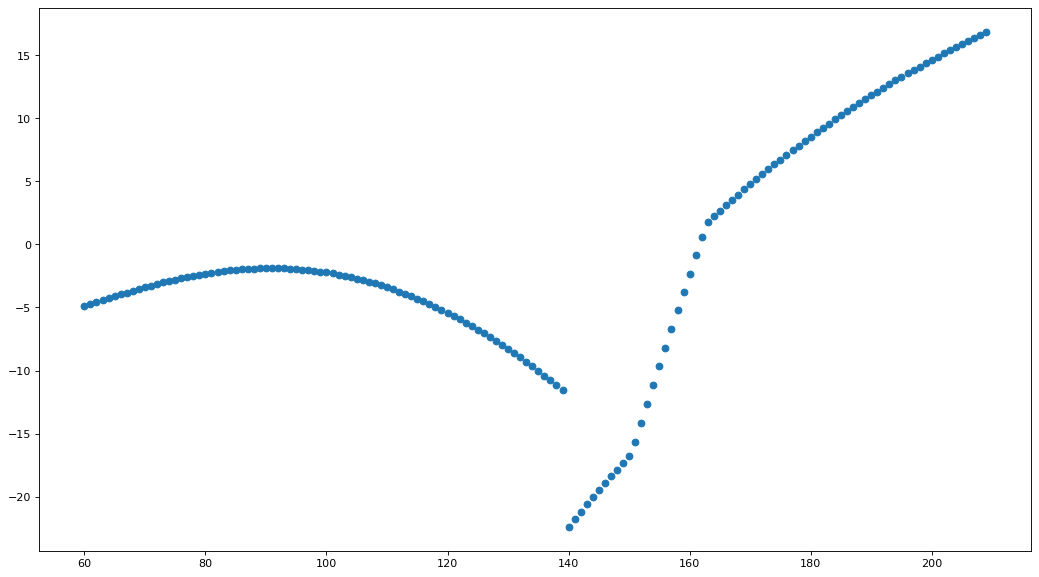

In [51]:
fig = plt.figure(figsize = (16,9), dpi = 80)
plt.scatter(K,pnl_option)

In [41]:
#option_buyer_pnl(S, K, T, r, q, sigma, t, S1, S2)

In [39]:
pnl_on_stock = (Adj_Close_20221101 - Adj_Close_20220801) * shares
pnl_on_stock

-106183.4716796875

In [40]:
S = Adj_Close_20220801 
K = 162
T = 90/360
t = 60/360
r = 0.045 
q = 0.0065 
sigma = sigma_annually
S1 = Adj_Close_20220930 
S2 = Adj_Close_20221101
o_price = chooser_option_Cl(S, K, T, r, q, sigma, t)
o_price

11.077456411553698

In [42]:
S = Adj_Close_20220801
S

161.0188446044922

In [166]:
S = Adj_Close_20220801 
K = 130
T = 90/360
t = 60/360
r = 0.045 
q = 0.0065 
sigma = sigma_annually
S1 = Adj_Close_20220930 
S2 = Adj_Close_20221101

o_price = chooser_option_Cl(S, K, T, r, q, sigma, t)
o_price   
    # at time 0, build up portfolio
#delta = CHOOSER_DELTA(S, K, T, t, r, q, sig = sigma_annually) # chooser option delta at 08/01, and premium
#contracts = (- shares * Adj_Close_20220801) / delta
#premium = contracts * o_price

28.725255044568605

In [173]:
shares = 1

In [174]:
delta = CHOOSER_DELTA(S, K, T, t, r, q, sig = sigma_annually) # chooser option delta at 08/01, and premium
contracts = (- shares * Adj_Close_20220801) / delta
premium = contracts * o_price
premium

-17155.06399794809

In [175]:
c = black_scholes_call(S1, K = 162.5, T = 30/360, r = 0.045, q = 0.0065, sigma = sigma_annually)
p = c + 162.5 * np.exp(-r * 30/360) - S1
print(c)
print(p)

-4.485718231237193
19.434932807698402


In [176]:
pnl = (S2 - S) * shares + (S2 - K) * contracts - premium
pnl

4961.025903632528

In [177]:
(S2 - S) * shares

-10.618362426757812

In [178]:
(S2 - K) * contracts

-12183.419731888805

In [179]:
- premium

17155.06399794809

In [194]:
# run 100 different scenario with different K hoding T,t unchanged.
PnL = []
K = np.arange(110, 190, 0.5)
for i in range(0,160):
    p_l = delta_neutral_pnl(S = Adj_Close_20220801, K = K[i], \
                            T = 90/360, t = 60/360, r = 0.045, q = 0.0065, sigma = sigma_annually, \
                           S1 = Adj_Close_20220930, S2 = Adj_Close_20221101)
    PnL.append(p_l)

NameError: name 'delta_neutral_pnl' is not defined

(-1000000000.0, 1000000000.0)

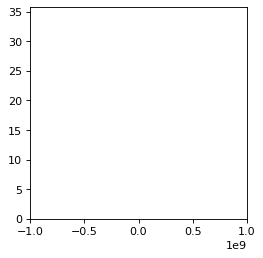

In [193]:
fig = plt.figure(figsize = (3.5,3.5), dpi = 80)
plt.hist(PnL, bins = 600)
plt.xlim(-1000000000, 1000000000)

In [421]:
np.median(PnL) 

12485.740189741122

In [407]:
Adj_Close_20220801 * 10000

1615099.9450683594

In [406]:
Adj_Close_20220801 
Adj_Close_20220930 
(Adj_Close_20221101 -  Adj_Close_20220801) * 10000 

-108600.00610351562

# Dynamic Delta Hedging

In [ ]:
# Think yourself as an option seller, or as a banker. Selling options to investers, buying or selling stocks to
# neutralize the portfolio's delta.

# Assume we sell one 3-month chooser option contract (mutiplier x100) at 08/01 (t1), calculate delta, initialize
# stock position, calculate delta everyday at market closed, rebalance. Calculate pnl at that day. 

# 

In [52]:
adj_close_08011101 = aapl["Close"][187:253]

In [53]:
len(adj_close_08011101)

66

In [54]:
adj_close_08011101

Date
2022-08-01    161.018845
2022-08-02    159.523407
2022-08-03    165.624817
2022-08-04    165.305786
2022-08-05    165.076172
                 ...    
2022-10-26    149.102661
2022-10-27    144.560196
2022-10-28    155.482086
2022-10-31    153.086044
2022-11-01    150.400497
Name: Close, Length: 66, dtype: float64

In [55]:
adj_close_08011101['2022-09-30']

137.9711151123047

In [56]:
adj_close_08011101[-1]

150.40049743652344

In [57]:
# calculate option price, delta, build up portfolio at t0
adj_close_08011101[0]

161.0188446044922

In [58]:
option_price_t0 = chooser_option_Cl(S = adj_close_08011101[0], K = 150, T = 90/360, r = 0.045, q = 0.0065, \
                                    sigma = sigma_annually, t = 60/360)

In [59]:
option_price_t0

16.791850142595877

In [62]:
option_delta_t0 = CHOOSER_DELTA(S = adj_close_08011101[0], K = 150, T = 90/360, r = 0.045, q = 0.0065, \
                                    sig = sigma_annually, t = 60/360)

In [63]:
option_delta_t0

0.10802854160405329

In [64]:
# hedging 
shares = - (option_delta_t0 * 100 * 100) / adj_close_08011101[0]

In [65]:
shares

-6.70906202745411

In [492]:
cost_of_hedge = shares * adj_close_08011101[0]
cost_of_hedge

-1110.9402585583484

In [506]:
url = 'https://github.com/Riley25/FE-800/blob/main/AAPL__2022-11-07.xlsx?raw=true'
df=pd.read_excel(url) 
df[180:200] 

,CONTRACT_SYMBOL_CALL,STRIKE,BID_CALL,ASK_CALL,MID_PRICE_CALL,VOLUME_CALL,OPEN_INTEREST_CALL,IMPLIED_VOLATILITY_CALL,IN_THE_MONEY_CALL,CONTRACT_SYMBOL_PUT,...,ASK_PUT,MID_PRICE_PUT,VOLUME_PUT,OPEN_INTEREST_PUT,IMPLIED_VOLATILITY_PUT,IN_THE_MONEY_PUT,EXPIRATION_DATE,SNAPSHOT_DATE,TIME_TO_MATURITY_(YRS),STOCK_PRICE
180,AAPL221202C00090000,90.0,49.05,49.40,49.225,10.0,10,0.868165,True,AAPL221202P00090000,...,0.08,0.070,99.0,2503,0.699222,False,2022-12-02,2022-11-07,0.099206,138.92
181,AAPL221202C00105000,105.0,32.45,36.45,34.450,2.0,1,0.666507,True,AAPL221202P00105000,...,0.18,0.170,121.0,909,0.539067,False,2022-12-02,2022-11-07,0.099206,138.92
182,AAPL221202C00110000,110.0,29.40,29.65,29.525,2.0,5,0.592778,True,AAPL221202P00110000,...,0.24,0.240,115.0,925,0.490239,False,2022-12-02,2022-11-07,0.099206,138.92
183,AAPL221202C00115000,115.0,24.60,24.80,24.700,1.0,5,0.534673,True,AAPL221202P00115000,...,0.39,0.380,135.0,438,0.453619,False,2022-12-02,2022-11-07,0.099206,138.92
184,AAPL221202C00120000,120.0,19.85,20.05,19.950,1.0,31,0.492193,True,AAPL221202P00120000,...,0.65,0.645,539.0,823,0.419928,False,2022-12-02,2022-11-07,0.099206,138.92
185,AAPL221202C00125000,125.0,15.25,15.50,15.375,13.0,14,0.442633,True,AAPL221202P00125000,...,1.15,1.145,342.0,1082,0.394659,False,2022-12-02,2022-11-07,0.099206,138.92
186,AAPL221202C00127000,127.0,13.60,13.80,13.700,2.0,2,0.428961,True,AAPL221202P00127000,...,1.45,1.440,18.0,550,0.386237,False,2022-12-02,2022-11-07,0.099206,138.92
187,AAPL221202C00128000,128.0,12.85,12.95,12.900,2.0,1,0.420294,True,AAPL221202P00128000,...,1.62,1.610,51.0,327,0.381598,False,2022-12-02,2022-11-07,0.099206,138.92
188,AAPL221202C00129000,129.0,12.05,12.15,12.100,80.0,9,0.414923,True,AAPL221202P00129000,...,1.81,1.805,13.0,215,0.377203,False,2022-12-02,2022-11-07,0.099206,138.92
189,AAPL221202C00130000,130.0,11.25,11.45,11.350,211.0,187,0.416510,True,AAPL221202P00130000,...,2.05,2.035,666.0,1833,0.375617,False,2022-12-02,2022-11-07,0.099206,138.92


In [505]:
1/12

0.08333333333333333

# Dynamic Hedging Strategy

In [67]:
adj_close_08011101 = aapl["Close"][187:253]
adj_close_08010930 = adj_close_08011101[0:43]
adj_close_0930 = adj_close_08011101['2022-09-30']
adj_close_09301101 = adj_close_08011101[43:66]
print(adj_close_0930)

137.9711151123047


In [68]:
# premium 100 contracts (x100)
price = chooser_option_Cl(S = adj_close_08011101[0], K = 162.5, T = 90/360, r = 0.045, q = 0.0065, \
                            sigma = sigma_annually, t = 60/360)
premium = price * 100 * 100
print(premium)

107949.83193999676


In [69]:
option_delta_daily = []
for i in range(len(adj_close_08010930)):
    delta = CHOOSER_DELTA(S = adj_close_08010930[i], K = 162.5, T = (90 - i)/360, t = (60 - i)/360, r = 0.045,\
                          q = 0.0065, sig = sigma_annually)
    option_delta_daily.append(delta)
for i in range(len(adj_close_09301101)):
    d1 = (np.log(adj_close_09301101[i]/162.5) + (0.045 - 0.0065 + sigma_annually**2/2)*(30 - i)/360) / sigma_annually*np.sqrt(30/360)
    delta = - norm.cdf(- d1)
    option_delta_daily.append(delta)

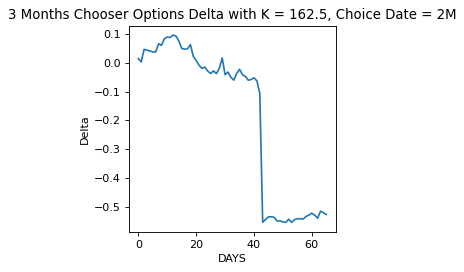

In [71]:
fig = plt.figure(figsize = (3.5,3.5), dpi = 80)
plt.plot(option_delta_daily)

plt.xlabel('DAYS')
plt.ylabel('Delta')
plt.title('3 Months Chooser Options Delta with K = 162.5, Choice Date = 2M')
plt.tight_layout()

In [101]:
# stock position
position = []
for i in range(len(adj_close_08011101)):
    shares = - (option_delta_daily[i] * 100 * 100) / adj_close_08011101[i]
    position.append(round(shares))
np.array(position)

array([-1,  0, -3, -3, -2, -2, -2, -4, -4, -5, -5, -5, -5, -5, -4, -3, -3,
       -3, -4, -1,  0,  1,  1,  1,  2,  2,  2,  2,  1, -1,  3,  2,  3,  4,
        2,  1,  3,  3,  4,  4,  3,  4,  7, 40, 38, 37, 36, 37, 39, 39, 40,
       40, 38, 40, 38, 38, 38, 38, 36, 35, 34, 35, 37, 33, 34, 35])

In [70]:
position1 = copy.deepcopy(position)
del position1[0]
del position[-1]
array1 = np.array(position)
array2 = np.array(position1)
operation = array2 - array1
operation

array([ 1, -3,  0,  1,  0,  0, -2,  0, -1,  0,  0,  0,  0,  1,  1,  0,  0,
       -1,  3,  1,  1,  0,  0,  1,  0,  0,  0, -1, -2,  4, -1,  1,  1, -2,
       -1,  2,  0,  1,  0, -1,  1,  3, 33, -2, -1, -1,  1,  2,  0,  1,  0,
       -2,  2, -2,  0,  0,  0, -2, -1, -1,  1,  2, -4,  1,  1])

In [71]:
operation = np.insert(operation, 0, -1)
operation

array([-1,  1, -3,  0,  1,  0,  0, -2,  0, -1,  0,  0,  0,  0,  1,  1,  0,
        0, -1,  3,  1,  1,  0,  0,  1,  0,  0,  0, -1, -2,  4, -1,  1,  1,
       -2, -1,  2,  0,  1,  0, -1,  1,  3, 33, -2, -1, -1,  1,  2,  0,  1,
        0, -2,  2, -2,  0,  0,  0, -2, -1, -1,  1,  2, -4,  1,  1])

In [72]:
print(sum(operation))

35


In [73]:
array3 = np.array(adj_close_08011101)
position_dollar = operation * array3
position_dollar

array([-161.0188446 ,  159.52340698, -496.87445068,    0.        ,
        165.07617188,    0.        ,    0.        , -337.91946411,
          0.        , -171.81498718,    0.        ,    0.        ,
          0.        ,    0.        ,  171.23594666,  167.29249573,
          0.        ,    0.        , -169.74841309,  490.04704285,
        161.11274719,  158.64683533,    0.        ,    0.        ,
        155.55195618,    0.        ,    0.        ,    0.        ,
       -157.109375  , -326.31866455,  614.34088135, -155.05278015,
        152.11764526,  150.45042419, -308.44830322, -156.64015198,
        306.93084717,    0.        ,  150.18086243,    0.        ,
       -151.50866699,  149.59184265,  426.73210144, 4553.04679871,
       -284.42816162, -145.85804749, -146.15753174,  145.18914795,
        279.7159729 ,    0.        ,  138.74983215,    0.        ,
       -285.50640869,  276.30166626, -284.34832764,    0.        ,
          0.        ,    0.        , -294.05221558, -149.20248

In [74]:
# hedging cost
sum(position_dollar)

4757.520889282227

In [75]:
#Pnl
pnlonoption = (162.5 - adj_close_08011101[-1]) * 100 * 100
optionbuyerpnl = pnlonoption - premium
print(optionbuyerpnl)

12424.057141616955


In [123]:
k = np.arange(100,200)
k[0]

100

In [141]:
def hedgepnl(s):
    k = np.arange(100,200)
    #adj_close_08011101 = aapl["Adj Close"][187:253]
    #adj_close_08010930 = adj_close_08011101[0:43]
    #adj_close_0930 = adj_close_08011101['2022-09-30']
    #adj_close_09301101 = adj_close_08011101[43:66]
    
    price = chooser_option_Cl(S = adj_close_08011101[0], K = k[s], T = 90/360, r = 0.045, q = 0.0065, \
                            sigma = sigma_annually, t = 60/360)
    premium = price * 100 * 100
    
    option_delta_daily = []
    for i in range(len(adj_close_08010930)):
        delta = CHOOSER_DELTA(S = adj_close_08010930[i], K = k[s], T = (90 - i)/360, t = (60 - i)/360, r = 0.045,\
                          q = 0.0065, sig = sigma_annually)
        option_delta_daily.append(delta)
    for l in range(len(adj_close_09301101)):
        d1 = (np.log(adj_close_09301101[l]/k[s]) + (0.045 - 0.0065 + sigma_annually**2/2)*(30 - l)/360) / sigma_annually*np.sqrt(30/360)
        delta = - norm.cdf(- d1)
        option_delta_daily.append(delta)
    
    position = []
    for p in range(len(adj_close_08011101)):
        shares = - (option_delta_daily[p] * 100 * 100) / adj_close_08011101[p]
        position.append(round(shares))
    #position = np.array(position)
    
    position1 = copy.deepcopy(position)
    del position1[0]
    del position[-1]
    array1 = np.array(position)
    array2 = np.array(position1)
    operation = array2 - array1
    
    operation = np.insert(operation, 0, -1)
    #sum(operation)
    array3 = np.array(adj_close_08011101)
    position_dollar = operation * array3
    h_cost = sum(position_dollar)
    
    pnlonoption = (k[s] - adj_close_08011101[-1]) * 100 * 100
    optionbuyerpnl = pnlonoption - premium
    return h_cost, optionbuyerpnl, - optionbuyerpnl - h_cost

In [142]:
#K = np.arange(60,210)
optionbuyerpnl = []
seller_pnl = []
hedge_cost = []
for s in range(0,100):
    result = hedgepnl(s)
    seller_pnl.append(result[2])
    optionbuyerpnl.append(result[1])
    hedge_cost.append(result[0])

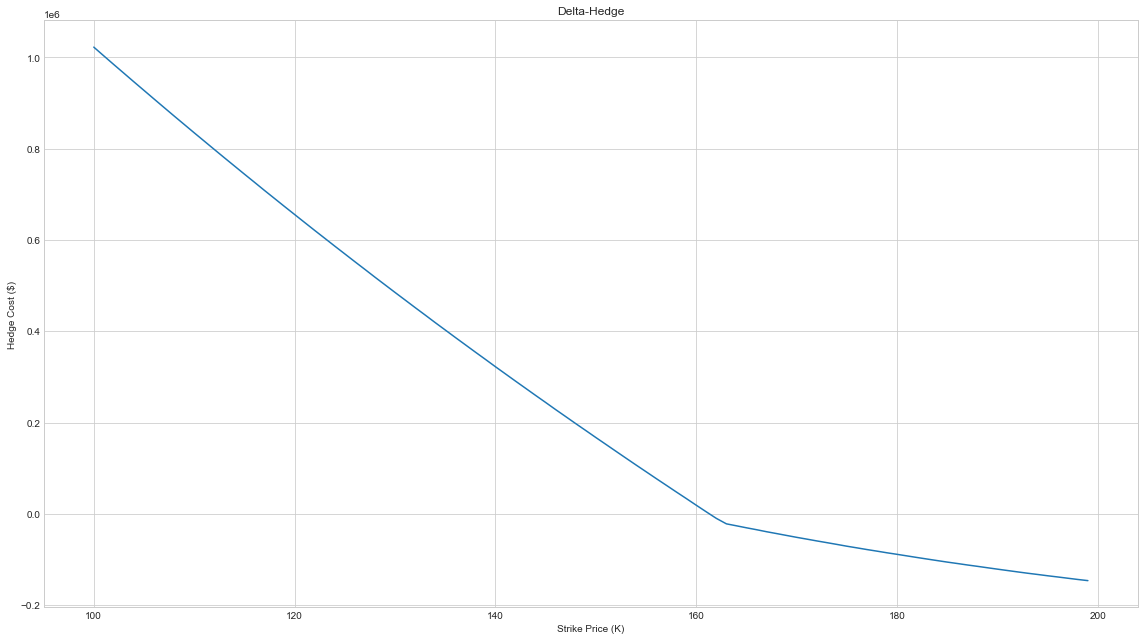

In [150]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(16,9))
    plt.plot(k, seller_pnl)

    plt.xlabel('Strike Price (K)')
    plt.ylabel('Hedge Cost ($)')
    plt.title('Delta-Hedge')

    plt.tight_layout()
    plt.savefig('delta-hedge_K-Pnl.jpg', dpi = 450 )
    plt.show()
#plt.plot(k, seller_pnl)

In [148]:
import os
os.getcwd()

'/Users/apple'

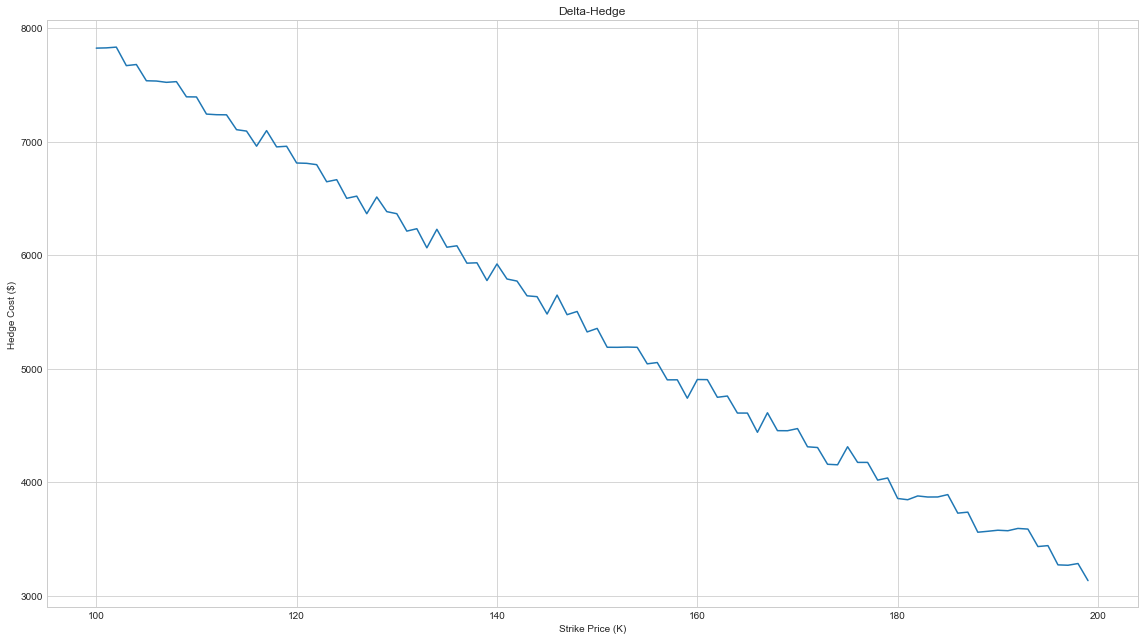

In [151]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(16,9))
    plt.plot(k, hedge_cost)

    plt.xlabel('Strike Price (K)')
    plt.ylabel('Hedge Cost ($)')
    plt.title('Delta-Hedge')

    plt.tight_layout()
    plt.savefig('delta-hedge_K-Pnl.jpg', dpi = 450 )
    plt.show()
#plt.plot(k, hedge_cost)

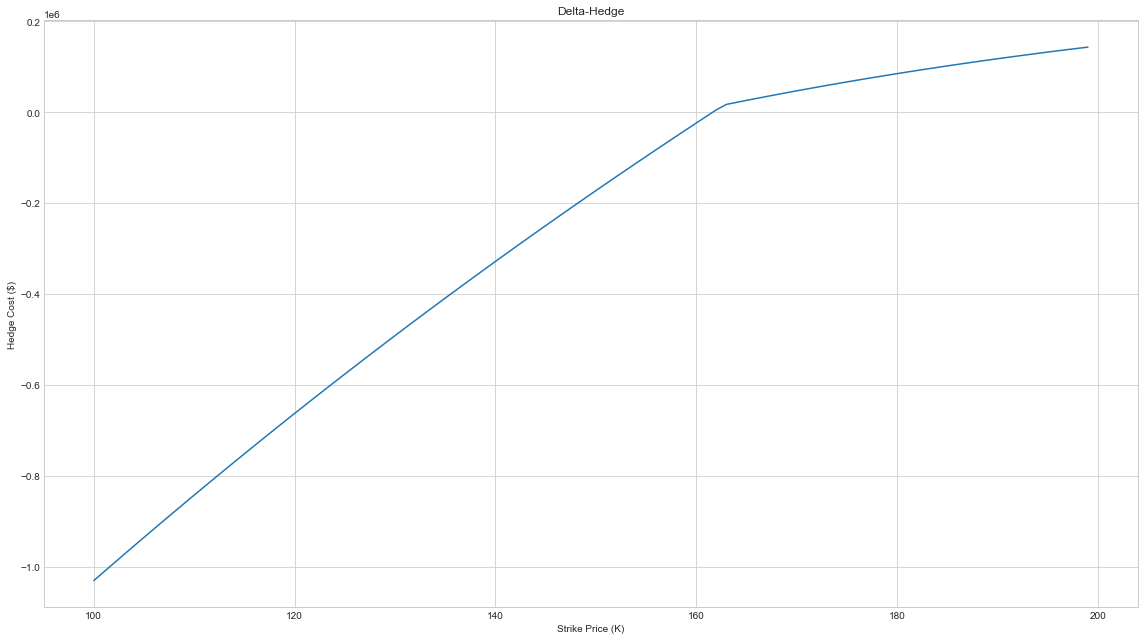

In [152]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(16,9))
    plt.plot(k, optionbuyerpnl)

    plt.xlabel('Strike Price (K)')
    plt.ylabel('Hedge Cost ($)')
    plt.title('Delta-Hedge')

    plt.tight_layout()
    plt.savefig('delta-hedge_K-Pnl.jpg', dpi = 450 )
    plt.show()
#plt.plot(k, optionbuyerpnl)

In [145]:
PnL = []
window = 50
for i in range(0, len(aapl)-window):
    S0 = aapl['Close'].iloc[i]
    St = aapl['Close'].iloc[i + window]
    ST = aapl['Close'].iloc[i + round(window / 2)]
    pl = option_buyer_pnl(S0, K = S0, T = window/360, r = 0.045, q = 0.0065, sigma = sigma_annually, t = window/720, S1=St, S2 = ST)
    PnL.append(pl)
PnL

[14.34796213340633,
 17.131956506245267,
 15.06426650639654,
 20.51227328726222,
 16.465379287092347,
 15.939762879157843,
 20.520216013771375,
 16.522933382627233,
 15.455583806437563,
 11.83353878675656,
 15.063021597786488,
 16.660168934968354,
 14.678574608494635,
 14.117120654818644,
 10.25547497708098,
 9.850647405675401,
 8.260029955583647,
 7.072032940342966,
 16.913128113034393,
 10.991858502147968,
 0.8844587032065174,
 -1.4775320745215517,
 -0.24414859897601815,
 1.7973191395261399,
 1.0234009358840446,
 -9.04627363434512,
 -6.362376309801212,
 -7.734905028452479,
 0.16667899092256988,
 0.2227551435058146,
 0.6072665442459844,
 7.414611145432223,
 1.536651374491644,
 2.315840483573748,
 1.0892941169914607,
 4.628077688423682,
 -3.9719720850453744,
 -7.81579140933775,
 -3.8098189150847332,
 -6.0248623143013145,
 -2.9996050793972415,
 -3.6072591478399083,
 -3.4739602602983553,
 -2.438609292575075,
 -6.076528376442116,
 -6.4439170046735335,
 -5.7296075896813825,
 -5.80859873221

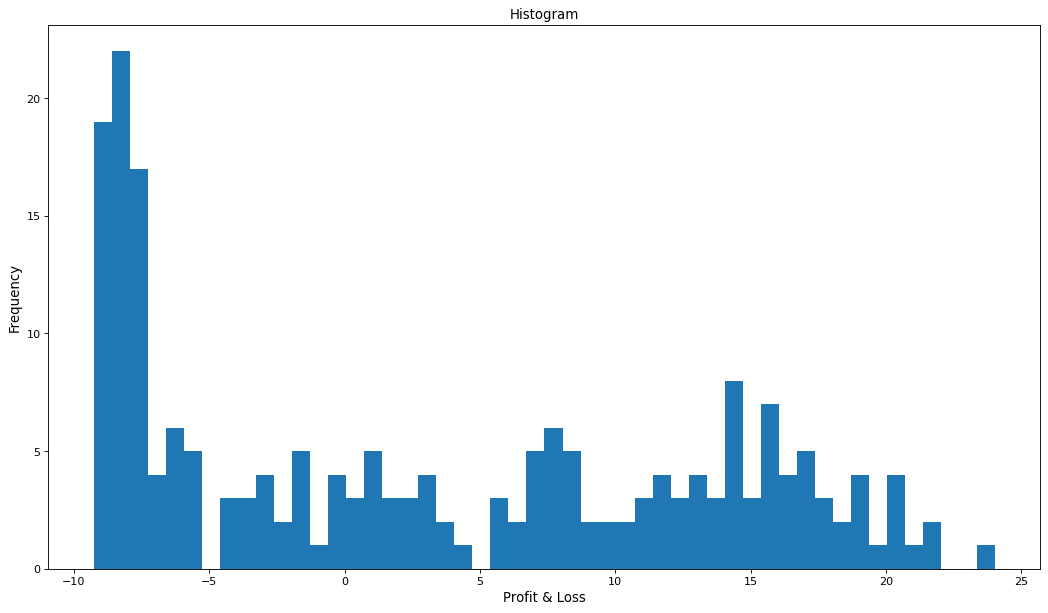

In [147]:
fig = plt.figure(figsize = (16,9), dpi = 80)
plt.hist(PnL, bins = 50)
plt.xlabel('Profit & Loss', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Histogram', fontsize = 12)
plt.savefig('Histogram_PNL.jpg', dpi = 550)
plt.show()

In [ ]:
predict_aapl = pd.read_csv('model_prediction_res.csv')
predict_aapl.head(10)

In [184]:
url = 'https://github.com/Riley25/FE-800/blob/main/GBM_JUMP_DF.xlsx?raw=true'
GBM_JUMP_DF_v2 = pd.read_excel(url)

In [185]:
n_row, n_col = GBM_JUMP_DF_v2.shape


In [186]:
GBM_JUMP_DF_v2[0][1]

69.43088663057317

In [190]:
PnL = []
#window = 50
for i in range(0, n_col):
    S0 = GBM_JUMP_DF_v2[i][0]
    St = GBM_JUMP_DF_v2[i][round(n_row / 2)]
    ST = GBM_JUMP_DF_v2[i][n_row - 1]
    pl = option_buyer_pnl(S0, K = S0, T = n_row/360, r = 0.045, q = 0.0065, sigma = sigma_annually, t = n_row/720, S1=St, S2 = ST)
    PnL.append(pl)
PnL

[-3.6712055551704603,
 1.5955597433805897,
 3.586656208545434,
 -1.7851143639413474,
 1.905160782419677,
 -2.6625241173940575,
 -3.6712055551704603,
 -3.6712055551704603,
 -0.21507842437725433,
 -2.0110183561182433,
 -3.2106780452813135,
 -3.6712055551704603,
 1.9013014070652252,
 3.9356142615600467,
 -3.6712055551704603,
 -3.6712055551704603,
 2.33403712940327,
 -3.6712055551704603,
 -0.9210405761260754,
 -2.3690978045565894,
 -3.6712055551704603,
 -3.6712055551704603,
 0.6077381218051405,
 -3.6712055551704603,
 -0.013828990337587221,
 -2.2458871268967338,
 -3.6712055551704603,
 -2.8934640144157564,
 -3.6712055551704603,
 -3.6712055551704603,
 -0.7192834487910753,
 -2.3454214263565953,
 0.07140387598418751,
 -0.9292749992938818,
 -0.7748639326369196,
 -2.9761500015640516,
 -1.390431622223148,
 3.1324474841191963,
 -3.6712055551704603,
 6.276853920851642,
 2.783032497364302,
 -0.903422420191391,
 -3.6712055551704603,
 -0.5562250691745882,
 3.066409924476175,
 -3.6712055551704603,
 3.39

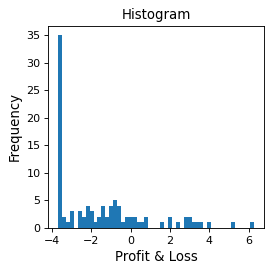

In [192]:
fig = plt.figure(figsize = (3.5, 3.5), dpi = 80)
plt.hist(PnL, bins = 50)
plt.xlabel('Profit & Loss', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Histogram', fontsize = 12)
plt.tight_layout()
plt.savefig('Histogram_PNL_prediction.jpg', dpi = 550)
plt.show()